# パッケージインポート

In [1]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()

PROJECT_ID = os.environ.get("PROJECT")
DATASET = os.environ.get("DATASET")

client = bigquery.Client(project=PROJECT_ID)

def bq(sql: str) -> pd.DataFrame:
    return client.query(sql).to_dataframe()

# 分析

## マーケティングチャネル分析

- **データソース：**
  - `fct_ga4__sessions_daily`: セッションレベルメトリクス（ページビュー、エンゲージメント）
  - `dim_ga4__sessions_daily`: セッション属性（チャネルグルーピング、日付）  


- **このクエリが答えるビジネス上の質問**
  1. どのマーケティングチャネルが最も多くのセッションを獲得しているか？
  2. チャネル間でエンゲージメント品質はどのように異なるか？
  3. 各チャネルの時系列トラフィック傾向はどのように変化しているか？
  4. どのチャネルが最も高いコンテンツ消費（ページビュー）を提供するか？  



- **洞察**
  - ディレクト、オーガニック、リファラルがTop3でトラフィック量が多く、更に深掘りの余地あり。
    - Top 3のどのチャネルもトラフィックの規則性が見られる
  - 年末ディップにディップが見られ、季節要因/施策停止が予想される
  - 複数チャネルの同時ピークが見られ、全社イベント（セール/ローンチ）起点の全体リフトの可能性。



/Users/nakanomizuki/Code/Mizuki8783/Mizuki8783/personal/ga4-bq-dbt/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,date,channel_group,sessions,pageviews,engagement_rate
0,2020-11-01,Affiliates,3,10,0.666667
1,2020-11-01,Direct,1051,1852,0.823977
2,2020-11-01,Organic Search,594,3097,0.922559
3,2020-11-01,Organic Social,2,10,1.000000
4,2020-11-01,Paid Search,61,337,0.934426


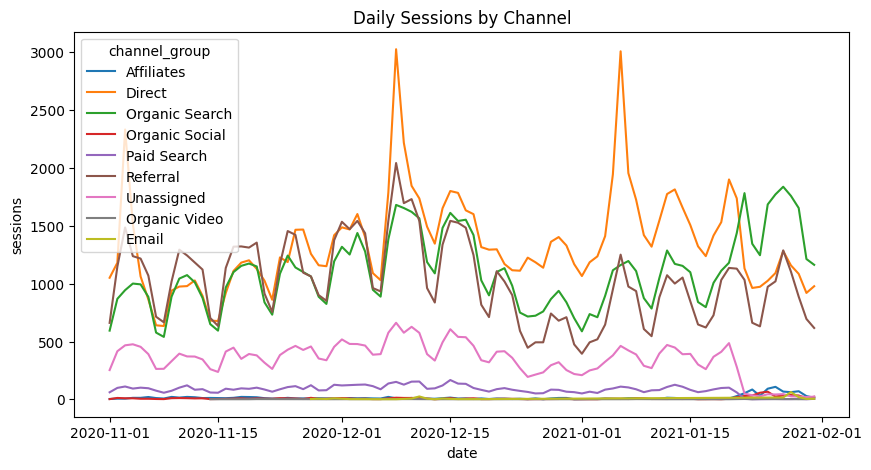

In [8]:
sql = f"""
select
  d.session_partition_date as date,
  coalesce(d.session_default_channel_grouping, 'Unassigned') as channel_group,
  count(*) as sessions,
  sum(f.session_partition_count_page_views) as pageviews,
  avg(cast(f.session_partition_max_session_engaged as float64)) as engagement_rate
from `{PROJECT_ID}.{DATASET}.fct_ga4__sessions_daily` f
join `{PROJECT_ID}.{DATASET}.dim_ga4__sessions_daily` d
  on f.session_key = d.session_key
 and f.session_partition_key = d.session_partition_key
group by 1, 2
order by 1, 2
"""
df = bq(sql)
display(df.head())

plt.figure(figsize=(10,5))
sns.lineplot(data=df, x="date", y="sessions", hue="channel_group")
plt.title("Daily Sessions by Channel")
plt.show()

/Users/nakanomizuki/Code/Mizuki8783/Mizuki8783/personal/ga4-bq-dbt/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,date,device_category,sessions,engagement_rate,avg_engaged_secs_per_session,avg_pages_per_session
0,2020-11-01,desktop,358,0.946927,90.998492,5.053073
1,2020-11-01,mobile,222,0.887387,102.839140,5.626126
2,2020-11-01,tablet,14,0.857143,47.452571,2.785714
3,2020-11-02,desktop,495,0.901010,90.218723,6.325253
4,2020-11-02,mobile,350,0.908571,105.323286,5.557143


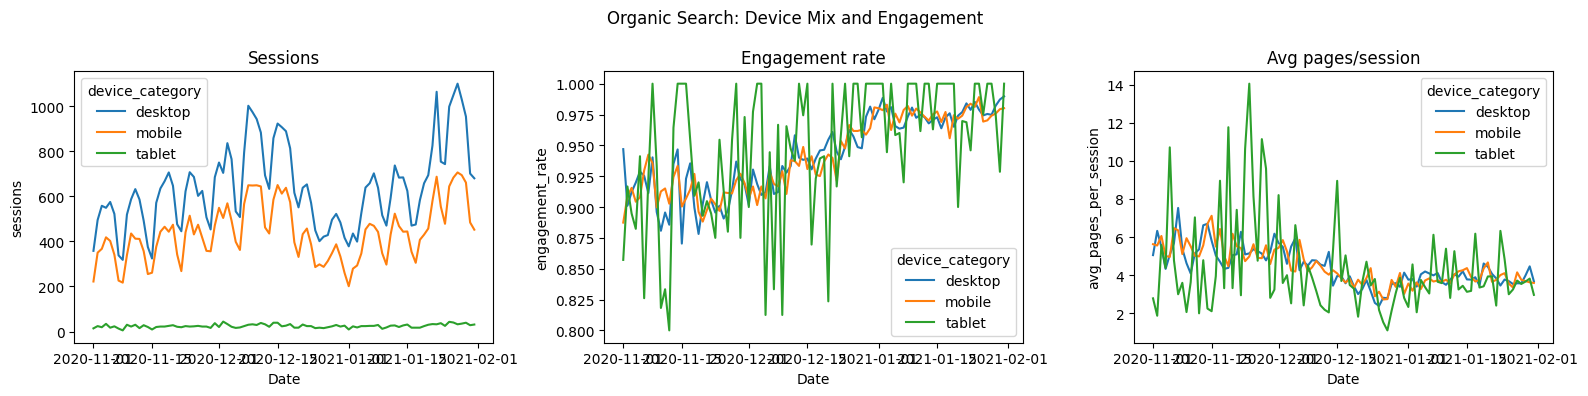

In [ ]:
CHANNEL_GROUP = "Organic Search"
sql = f"""
select
  d.session_partition_date as date,
  coalesce(d.device_category, 'unknown') as device_category,
  count(*) as sessions,
  avg(cast(f.session_partition_max_session_engaged as float64)) as engagement_rate,
  sum(f.session_partition_sum_engagement_time_msec) / 1000.0 / count(*) as avg_engaged_secs_per_session,
  sum(f.session_partition_count_page_views) / count(*) as avg_pages_per_session
from `{PROJECT_ID}.{DATASET}.fct_ga4__sessions_daily` f
join `{PROJECT_ID}.{DATASET}.dim_ga4__sessions_daily` d
  on f.session_key = d.session_key
 and f.session_partition_key = d.session_partition_key
where coalesce(d.session_default_channel_grouping, 'Unassigned') = '{CHANNEL_GROUP}'
group by 1,2
order by 1,2
"""
df_dev = bq(sql)
display(df_dev.head())

fig, axes = plt.subplots(1, 3, figsize=(16,4), sharex=True)
sns.lineplot(data=df_dev, x="date", y="sessions", hue="device_category", ax=axes[0])
axes[0].set_title("Sessions")
sns.lineplot(data=df_dev, x="date", y="engagement_rate", hue="device_category", ax=axes[1])
axes[1].set_title("Engagement rate")
sns.lineplot(data=df_dev, x="date", y="avg_pages_per_session", hue="device_category", ax=axes[2])
axes[2].set_title("Avg pages/session")
for ax in axes: ax.set_xlabel("Date")
plt.suptitle(f"{CHANNEL_GROUP}: Device Mix and Engagement")
plt.tight_layout()
plt.show()

## 新規・既存顧客分析

- **データソース**
  - `fct_ga4__pages`（日次ページファクト）

- **対象**
  - サイト全体を日次集計（`event_date_dt`）
  - 新規顧客数: `sum(new_client_keys)`
  - リピーター数: `sum(distinct_client_keys) - sum(new_client_keys)`

- **このクエリが答えるビジネス上の質問**
  1. 日次で新規とリピーターはどちらが多いか？その差はどれくらいか？
  2. 新規獲得・再訪のトレンドは直近で増加/減少しているか？
  3. 新規/リピーターの構成比は時間とともにどう変化しているか（季節性やキャンペーン影響の兆候）？
  4. 異常値やピーク/谷はいつ発生しているか（要因深掘りの候補日）？

- **洞察**
  - 全期間で新規が圧倒的多数。獲得ドリブンのトラフィック構成が見られる。
  - 新規に明確な週次リズム（周期的なピークと谷）が見られる。曜日要因や配信スケジュールの影響が濃いと予想される。
  - リピーター（復帰）のボリュームは新規に比べてかなり小さく、リテンションの相対的弱さが懸念される。

- **データ面の注意点（重要）**
  - リピーターが負値になっているのは算出ロジックの不整合の可能性。通常は `returning = distinct_clients - new_clients` は負にならない。
  - 粒度不一致（ページ粒度での重複集計→日次でSUMしている等）や、`distinct_client_keys` の定義が「日次ユニーク」以外になっている可能性が高い。
  - 対処方針: 日付粒度でまず「日次ユニーク」と「日次新規」を集計し、その差分でリピーターを計算する。


/Users/nakanomizuki/Code/Mizuki8783/Mizuki8783/personal/ga4-bq-dbt/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


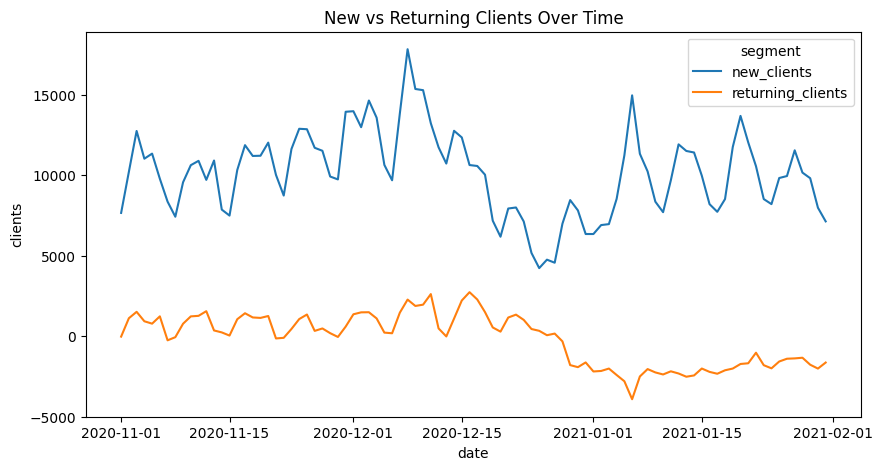

In [4]:
sql = f"""
select
  event_date_dt as date,
  sum(new_client_keys) as new_clients,
  sum(distinct_client_keys) - sum(new_client_keys) as returning_clients
from `{PROJECT_ID}.{DATASET}.fct_ga4__pages`
group by 1
order by 1
"""
nr = bq(sql)

nr_melt = nr.melt(id_vars="date", value_vars=["new_clients","returning_clients"],
                  var_name="segment", value_name="clients")
plt.figure(figsize=(10,5))
sns.lineplot(data=nr_melt, x="date", y="clients", hue="segment")
plt.title("New vs Returning Clients Over Time")
plt.show()

**顧客を新規・既存に分別した際の各マーケティングチャネルのパフォーマンスを調査**

- **洞察**
  - 獲得はDirect/Organic/Referralがボリューム源、ただし既存顧客に対っするDirectの質改善が必要とされる
  - Paid Searchは新規効率が高い→リマーケ/オンボーディングで再訪化を設計
  - Unassignedが大きい→UTM/チャネル定義の整備で実態把握
  - 質の高いReferralパートナーを特定し連携深耕


/Users/nakanomizuki/Code/Mizuki8783/Mizuki8783/personal/ga4-bq-dbt/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,channel_group,segment,sessions,engagement_rate,avg_pages_per_session
0,Affiliates,new,745,1.000000,3.845638
1,Affiliates,returning,611,0.603928,2.610475
2,Direct,new,98375,0.998465,1.976640
3,Direct,returning,25300,0.432134,1.436561
4,Email,new,74,1.000000,8.554054
5,Email,returning,119,0.873950,8.504202
6,Organic Search,new,80771,0.999814,4.164428
7,Organic Search,returning,20541,0.720413,5.200574
8,Organic Social,new,418,1.000000,6.435407
9,Organic Social,returning,375,0.818667,4.810667


segment,new,returning,total,share_new
channel_group,,,,
Direct,98375,25300,123675,0.795432
Organic Search,80771,20541,101312,0.79725
Referral,50151,43637,93788,0.534727
Unassigned,23924,7980,31904,0.749875
Paid Search,7263,435,7698,0.943492
Affiliates,745,611,1356,0.54941
Organic Social,418,375,793,0.527112
Email,74,119,193,0.38342
Organic Video,20,17,37,0.540541


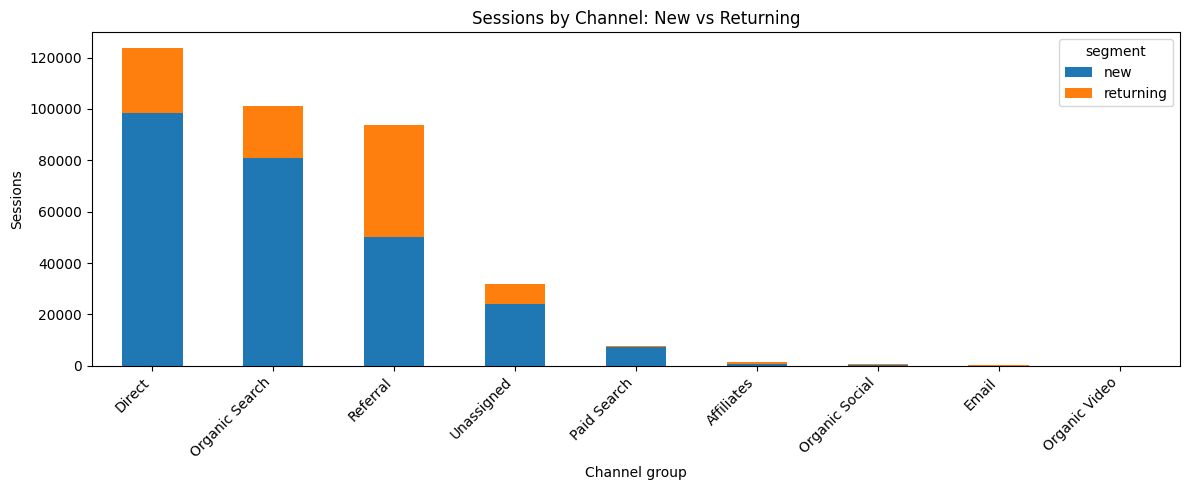

In [3]:
# Optional date window
START_DATE = None  # e.g., "2020-11-01"
END_DATE = None    # e.g., "2021-02-01"

date_where = ""
if START_DATE and END_DATE:
    date_where = f"where d.session_partition_date between date('{START_DATE}') and date('{END_DATE}')"

sql = f"""
with base as (
  select
    coalesce(d.session_default_channel_grouping, 'Unassigned') as channel_group,
    case when f.session_number = 1 then 'new' else 'returning' end as segment,
    cast(f.session_partition_max_session_engaged as float64) as engaged,
    f.session_partition_count_page_views as pageviews
  from `{PROJECT_ID}.{DATASET}.fct_ga4__sessions_daily` f
  join `{PROJECT_ID}.{DATASET}.dim_ga4__sessions_daily` d
    on f.session_key = d.session_key
   and f.session_partition_key = d.session_partition_key
  {date_where}
)
select
  channel_group,
  segment,
  count(*) as sessions,
  avg(engaged) as engagement_rate,
  avg(pageviews) as avg_pages_per_session
from base
group by 1,2
order by channel_group, segment
"""
channels = bq(sql)

# Table (wide)
tbl = channels.pivot_table(index="channel_group", columns="segment", values="sessions", aggfunc="sum", fill_value=0)
tbl["total"] = tbl.sum(axis=1)
tbl["share_new"] = (tbl.get("new", 0) / tbl["total"]).replace([pd.NA, pd.NaT], 0)
display(channels.sort_values(["channel_group","segment"]))
display(tbl.sort_values("total", ascending=False))

# Stacked bar: sessions
plot_df = channels.pivot_table(index="channel_group", columns="segment", values="sessions", aggfunc="sum", fill_value=0).reset_index()
plot_df = plot_df.sort_values(by=["new","returning"], ascending=False)
ax = plot_df.set_index("channel_group")[["new","returning"]].plot(kind="bar", stacked=True, figsize=(12,5))
ax.set_ylabel("Sessions"); ax.set_xlabel("Channel group"); ax.set_title("Sessions by Channel: New vs Returning")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

**顧客を新規・既存に分別した際の各マーケティングチャネルのパフォーマンスを調査**


- **洞察**
   - 既存顧客と比べ、新規顧客の方がエンゲージメント率が高い傾向にある
   - 特にAffiliate、Direct、Organic Search、Paid Searchチャネルで新規ユーザーのエンゲージメント率が100%近い
     - *使用した式に問題がある可能性があるため、再確認が必要*
   - 一方、リピーターは全体的にエンゲージメント率が低下する傾向（60-90%程度）
   - ページビュー数では、OrganicチャネルとEmailで新規・リピーター共に高い値を示している
   - 新規獲得に強いチャネル（Direct、Organic Search）の質を維持しつつ、リピーター向けの施策が必要

/Users/nakanomizuki/Code/Mizuki8783/Mizuki8783/personal/ga4-bq-dbt/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,channel_group,segment,sessions,engagement_rate,avg_pages_per_session
5,Affiliates,new,745,1.000000,3.845638
9,Affiliates,returning,611,0.603928,2.610475
7,Direct,new,98375,0.998465,1.976640
2,Direct,returning,25300,0.432134,1.436561
6,Email,new,74,1.000000,8.554054
15,Email,returning,119,0.873950,8.504202
4,Organic Search,new,80771,0.999814,4.164428
14,Organic Search,returning,20541,0.720413,5.200574
10,Organic Social,new,418,1.000000,6.435407
16,Organic Social,returning,375,0.818667,4.810667


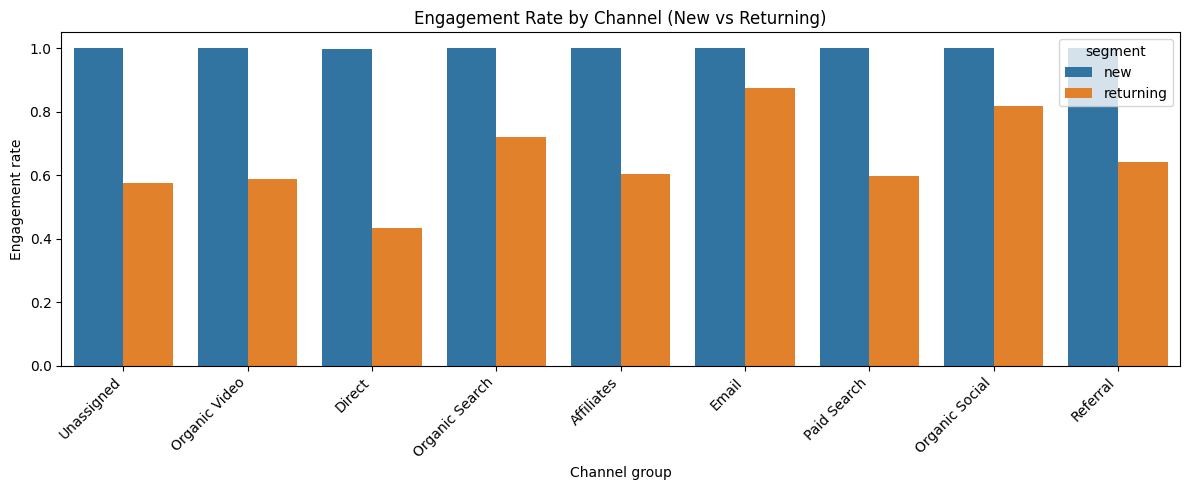

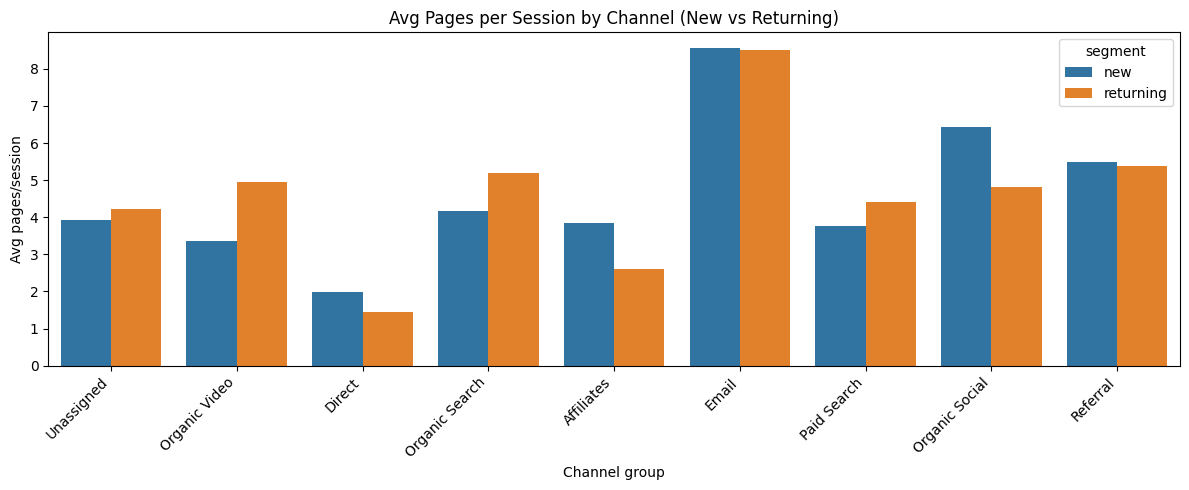

In [5]:
sql = f"""
with base as (
  select
    coalesce(d.session_default_channel_grouping, 'Unassigned') as channel_group,
    case when f.session_number = 1 then 'new' else 'returning' end as segment,
    cast(f.session_partition_max_session_engaged as float64) as engaged,
    f.session_partition_count_page_views as pageviews
  from `{PROJECT_ID}.{DATASET}.fct_ga4__sessions_daily` f
  join `{PROJECT_ID}.{DATASET}.dim_ga4__sessions_daily` d
    on f.session_key = d.session_key
   and f.session_partition_key = d.session_partition_key
  {date_where}
)
select
  channel_group,
  segment,
  count(*) as sessions,
  avg(engaged) as engagement_rate,
  avg(pageviews) as avg_pages_per_session
from base
group by 1,2
"""
quality = bq(sql)
display(quality.sort_values(["channel_group","segment"]))

plt.figure(figsize=(12,5))
sns.barplot(data=quality, x="channel_group", y="engagement_rate", hue="segment")
plt.title("Engagement Rate by Channel (New vs Returning)")
plt.ylabel("Engagement rate"); plt.xlabel("Channel group")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,5))
sns.barplot(data=quality, x="channel_group", y="avg_pages_per_session", hue="segment")
plt.title("Avg Pages per Session by Channel (New vs Returning)")
plt.ylabel("Avg pages/session"); plt.xlabel("Channel group")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()